In [5]:
import pandas as pd
import numpy as np

In [6]:
patients_df = pd.read_csv('Prod//mohs_patients_10000.csv')

In [7]:
patients_df

,PatientID,Complexity,TumorType,Location,TumorDiameter_mm,HistologicSubtype,SpeaksEnglish,Age,Immunosuppressed
0,Patient_00001,Simple,Basal Cell Carcinoma,Ear,5.5,Basosquamous,English,62,No
1,Patient_00002,Simple,Melanoma in situ,Forehead,8.8,Infiltrative,English,89,No
2,Patient_00003,Complex,Squamous Cell Carcinoma,Forehead,11.4,Desmoplastic,Non-English,50,No
3,Patient_00004,Simple,Melanoma in situ,Forehead,4.1,Desmoplastic,English,45,No
4,Patient_00005,Simple,Basal Cell Carcinoma,Ear,3.0,Superficial,English,66,No
...,...,...,...,...,...,...,...,...,...
9995,Patient_09996,Simple,Basal Cell Carcinoma,Forehead,7.4,Infiltrative,English,44,No
9996,Patient_09997,Complex,Basal Cell Carcinoma,Nose,9.3,Keratoacanthoma-like,English,82,No
9997,Patient_09998,Simple,Basal Cell Carcinoma,Neck,3.4,Keratoacanthoma-like,English,85,No
9998,Patient_09999,Simple,Basal Cell Carcinoma,Eyelid,5.1,Morpheaform,Non-English,56,Yes


In [8]:
patients_df.drop(columns=['PatientID'], inplace=True)

In [9]:
input = patients_df.drop(columns=['Complexity'])
output = patients_df["Complexity"]

In [10]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [11]:
categorical_features = ['TumorType', 'Location', 'HistologicSubtype', 'SpeaksEnglish', 'Immunosuppressed']
numerical_features = ['TumorDiameter_mm', 'Age']

label_encoder = LabelEncoder()
output_encoded = label_encoder.fit_transform(output)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

In [12]:
input_train_pre, input_test_pre, output_train, output_test = train_test_split(
    input, output_encoded, test_size=0.2, random_state=25
)

input_train = preprocessor.fit_transform(input_train_pre)
input_test = preprocessor.transform(input_test_pre)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
model = create_model(input_train.shape[1])

history = model.fit(
    input_train, output_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7859 - loss: 0.4920 - val_accuracy: 0.8800 - val_loss: 0.3235
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8993 - loss: 0.2936 - val_accuracy: 0.8813 - val_loss: 0.3185
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8998 - loss: 0.2757 - val_accuracy: 0.8844 - val_loss: 0.3176
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8977 - loss: 0.2810 - val_accuracy: 0.8794 - val_loss: 0.3177
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9032 - loss: 0.2691 - val_accuracy: 0.8813 - val_loss: 0.3188
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9026 - loss: 0.2692 - val_accuracy: 0.8775 - val_loss: 0.3181
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9000 - loss: 0.2731 - val_accuracy: 0.8763 - val_loss: 0.3226
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8971 - loss: 0.2758 - val_accuracy: 0.

In [15]:
loss, accuracy = model.evaluate(input_test, output_test, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8979 - loss: 0.2891  
Test Accuracy: 0.8925


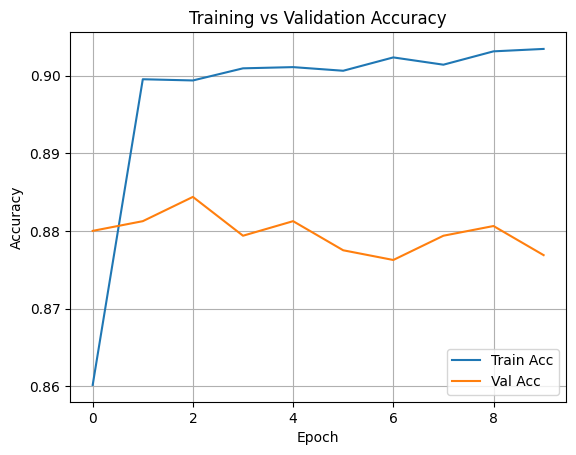

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_probs = model.predict(input_test)
y_pred = np.argmax(y_probs, axis=1) if y_probs.shape[1] > 1 else (y_probs > 0.5).astype(int).flatten()
y_true = output_test if isinstance(output_test, np.ndarray) else output_test.to_numpy()

precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
loss, accuracy = model.evaluate(input_test, output_test, verbose=1)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.8979 - loss: 0.2891
Test Accuracy: 0.8925
Precision: 0.8847
Recall:    0.9744
F1 Score:  0.9274
